In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import librosa
import os
import time
from tempfile import TemporaryDirectory
from torchvision import datasets, models, transforms
from sklearn.preprocessing import minmax_scale

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
os.environ['LIBROSA_CACHE_DIR'] = '/tmp/librosa_cache'  # Set a cache directory
def extract_spectogram(filepath):
    y, sr = librosa.load(filepath)
    n_fft = 3072  # Window size (Hanning window)
    hop_length = n_fft // 2  # 50% overlap

    # Compute spectrogram using a Hanning window
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, window='hann')

    # Convert power spectrogram to dB
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Compute MFCC features
    #mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    if (spectrogram_db.shape!=(128,431)):
        print('NOOOOOOOOOOOO    '+filepath)
    # Concatenate MFCC features with spectrogram
    #features = np.concatenate((spectrogram_db, mfcc), axis=0)

    return spectrogram_db

def extract_features(filepath):
    y, sr = librosa.load(filepath)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    cens = librosa.feature.chroma_cens(y=y, sr=sr)
    n_fft = 2048
    hop_length = 512
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    combined_features = np.concatenate([mfccs, centroid, cens, mel_spectrogram], axis=0)
    normalized_features = minmax_scale(combined_features, axis=1) 
    return normalized_features

class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.inputs = []
        self.labels = []
        self.transform=transform
        for i in range(4):
            for filename in os.listdir(data + str(i)):
                audio_file = str(data + str(i) + "/" + filename)
                spectrogram = extract_features(audio_file)
                print(audio_file+' '+str(spectrogram.shape))
                if spectrogram is not None:  
                    self.inputs.append(spectrogram)
                    self.labels.append(i)


        self.inputs = np.stack(self.inputs)
        self.labels = np.array(self.labels)

        self.inputs = torch.tensor(self.inputs, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        item = self.inputs[idx]
        target = self.labels[idx]

        if self.transform:
            item = self.transform(item)

        return item, target
    
transform=transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])
#db=MyDataset('./data/1200songs2/',transform=transform)
db_test=MyDataset('./data/1200songs2_test/',transform=transform)

./data/1200songs2_test/0/23 Blonde Redhead.mp3 (161, 1292)
./data/1200songs2_test/0/9 Crimes Damien Rice.mp3 (161, 1292)
./data/1200songs2_test/0/Algo Rhythm One Sentence. Supervisor.mp3 (161, 1292)
./data/1200songs2_test/0/Alison Slowdive.mp3 (161, 1292)
./data/1200songs2_test/0/All I Want Kodaline.mp3 (161, 1292)
./data/1200songs2_test/0/All Mirrors Angel Olsen.mp3 (161, 1292)
./data/1200songs2_test/0/All of Me John Legend.mp3 (161, 1292)
./data/1200songs2_test/0/Anchor Novo Amor.mp3 (161, 1292)
./data/1200songs2_test/0/Andromeda Weyes Blood.mp3 (161, 1292)
./data/1200songs2_test/0/Angel's Song Arlo Parks.mp3 (161, 1292)
./data/1200songs2_test/0/Angels The xx.mp3 (161, 1292)
./data/1200songs2_test/0/Another One Mac DeMarco.mp3 (161, 1292)
./data/1200songs2_test/0/Ashes to Ashes Warpaint.mp3 (161, 1292)
./data/1200songs2_test/0/Ayayay Bratia Stereo, Tony Tonite.mp3 (161, 1292)
./data/1200songs2_test/0/Bad Feeling Muzz.mp3 (161, 1292)
./data/1200songs2_test/0/Bad Kingdom May.mp3 (161, 

In [3]:
#print(db.inputs.shape)
#dataloader=torch.utils.data.DataLoader(db,batch_size=4,shuffle=True)

dataloader_test=torch.utils.data.DataLoader(db_test,batch_size=4,shuffle=False)

#inp,lab=next(iter(dataloader))
#print(inp.shape)

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    
                    labels = labels.to(device)
                    labels=labels.long()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(db) #dataset_sizes[phase]
                epoch_acc = running_corrects.double() / len(db) #dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'train' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [7]:
import torch
from sklearn.model_selection import KFold

def train_model_cross_validation(model, criterion, optimizer, scheduler, num_epochs=25, k_folds=5):
    since = time.time()
    best_acc = 0.0
    
    # Assuming db contains your dataset
    
    kf = KFold(n_splits=k_folds, shuffle=True)
    fold = 0
    
    for train_indices, val_indices in kf.split(db):  # Split dataset into train and validation indices
        fold += 1
        print(f'Fold {fold}/{k_folds}')
        print('-' * 10)
        
        # Split the dataset into train and validation sets for this fold
        train_db = torch.utils.data.Subset(db, train_indices)
        val_db = torch.utils.data.Subset(db, val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_db, batch_size=4, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_db, batch_size=4, shuffle=False)
        
        # Create a temporary directory to save training checkpoints for this fold
        with TemporaryDirectory() as tempdir:
            best_model_params_path = os.path.join(tempdir, f'best_model_params_fold{fold}.pt')
            
            best_fold_acc = 0.0
            
            for epoch in range(num_epochs):
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)
                
                for phase in ['train','val']:
                    if phase == 'train':
                        model.train()
                    else:
                        model.eval()
                        
                    running_loss = 0.0
                    running_corrects = 0
                    
                    dataloader = train_loader if phase == 'train' else val_loader
                    
                    for inputs, labels in dataloader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        labels = labels.long()
                        
                        optimizer.zero_grad()
                        
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)
                            
                            if phase == 'train':
                                loss.backward()
                                optimizer.step()
                                
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                    
                    if phase == 'train':
                        scheduler.step()
                    
                    epoch_loss = running_loss / len(train_indices if phase == 'train' else val_indices)
                    epoch_acc = running_corrects.double() / len(train_indices if phase == 'train' else val_indices)
                    
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                    
                    if phase == 'val' and epoch_acc > best_fold_acc:
                        best_fold_acc = epoch_acc
                        torch.save(model.state_dict(), best_model_params_path)
            
            print(f'Fold {fold} completed.')
            print()
            
            # Accumulate the best accuracy across folds
            if best_fold_acc > best_acc:
                best_acc = best_fold_acc
                
            # Load the best model weights for this fold
            model.load_state_dict(torch.load(best_model_params_path))
            
    time_elapsed = time.time() - since
    print(f'Cross-validation complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best fold Acc: {best_acc:.4f}')
    
    return model


In [6]:

import torch.optim as optim
from torch.optim import lr_scheduler

model_conv = models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)
model_conv.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=2, bias=True)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
weight_decay = 0.001
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0009, momentum=0.9, weight_decay=weight_decay)
#optimizer_conv = optim.Adamax(model_conv.fc.parameters(), lr=0.0007, weight_decay=weight_decay)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_conv, T_max=25, eta_min=0.0001)
#model_ft = train_model_cross_validation(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)
#load model 
model_ft=model_conv
model_ft.load_state_dict(torch.load('models/9e4SGD_88acc.pth'))

model_ft.eval()




ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [8]:
from sklearn.metrics import classification_report
y_true=[]
y_pred=[]
with torch.no_grad():
    for inputs,labels in dataloader_test:
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_true+=labels.cpu().numpy().tolist()
        y_pred+=preds.cpu().numpy().tolist()

print('Resnet\n'+classification_report(y_true,y_pred))


Resnet
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.69      0.90      0.78        30
           2       0.73      0.63      0.68        30
           3       0.96      0.87      0.91        30

    accuracy                           0.80       120
   macro avg       0.81      0.80      0.80       120
weighted avg       0.81      0.80      0.80       120



In [9]:
torch.save(model_ft.state_dict(), 'models/9e4SGD_88acc.pth')

In [35]:


model_ft.eval()
inputs,labels=next(iter(dataloader))
pred=model_ft(inputs.to(device))
print(pred,labels)


tensor([[-1.3225,  1.3678,  1.1779, -0.9443],
        [-0.9632,  0.7935,  0.9988, -0.6585],
        [-1.9320,  1.3369,  0.6047, -0.6835],
        [ 1.4550, -0.6970, -1.0815,  0.0928]], device='cuda:0',
       grad_fn=<AddmmBackward0>) tensor([1, 2, 2, 0], dtype=torch.int32)


In [89]:
def test_model(model, criterion, test_loader):
    model.eval() 
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.long()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(outputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')
    
    return test_loss, test_acc

test_model(model_ft,criterion,dataloader_test)


tensor([[-1.5496,  0.3005,  2.5781, -0.5840],
        [ 3.0047, -0.2017, -1.8899,  0.5389],
        [ 0.4628,  0.2388,  2.1001, -1.2916],
        [ 1.3364, -0.8236,  1.4473, -0.5437]], device='cuda:0')
tensor([[ 4.0743, -1.1641, -2.2063,  0.7502],
        [ 2.0891,  0.6695, -0.0290, -1.6275],
        [ 2.6772, -0.8465, -1.0184,  0.8051],
        [ 2.0021, -0.9302, -1.2874,  1.7271]], device='cuda:0')
tensor([[ 1.5424, -0.0161, -0.4128,  0.2144],
        [ 2.5297,  0.3476, -0.9629, -0.7559],
        [ 2.1320, -1.1994, -1.3180,  1.7817],
        [ 0.9248,  0.6985,  0.0841, -1.0417]], device='cuda:0')
tensor([[ 0.1351,  1.1352,  0.4448, -0.6969],
        [ 2.4958,  0.8916, -1.3222, -0.7302],
        [ 3.0542, -0.0871, -1.6092, -0.3465],
        [ 2.5553, -0.6231, -1.4648,  0.8954]], device='cuda:0')
tensor([[ 1.2937, -0.0842, -0.4197,  0.6929],
        [ 2.1112, -0.1671, -1.1452,  0.5733],
        [-0.2608,  2.1130,  0.9060, -1.8189],
        [ 3.0934,  0.3945, -1.1811, -1.0029]], device=

(0.5957664955407381, tensor(0.8000, device='cuda:0', dtype=torch.float64))

In [101]:

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the input numpy array to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor
])

# Define your function to apply the transform to the input spectrogram
def preprocess_spectrogram(spectrogram, transform):
    return transform(spectrogram)

preds = []
model_ft.to(device)
model_ft.eval()

i = 0
features = []

for filename in os.listdir('D:\\Licenta\\Backend\\Research\\ModelTraining\\data\\1200songs2_test\\2\\'):
    audio_file = str('D:\\Licenta\\Backend\\Research\\ModelTraining\\data\\1200songs2_test\\2\\' + filename)
    spectogram = extract_features(audio_file)
    spectogram = preprocess_spectrogram(spectogram, transform)
    spectogram = spectogram.unsqueeze(0).to(device).float()
    output = model_ft(spectogram)
    _, pr = torch.max(output, 1)
    preds.append(pr.item())
     


print(preds)


[2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2]


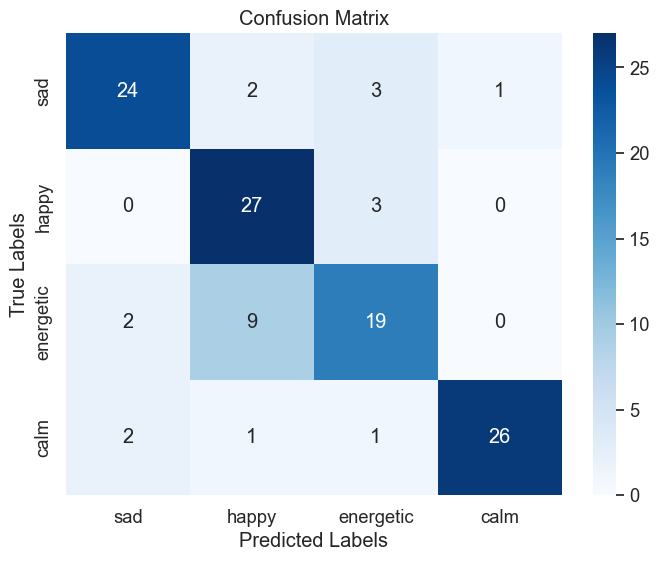

In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def generate_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    confusion_matrix_data = confusion_matrix(all_labels, all_preds)
    return confusion_matrix_data

confusion_matrix_data = generate_confusion_matrix(model_ft, dataloader_test)

def plot_confusion_matrix(confusion_matrix_data, classes):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['sad', 'happy', 'energetic', 'calm']
confusion_matrix_data = generate_confusion_matrix(model_ft, dataloader_test)

plot_confusion_matrix(confusion_matrix_data, class_names)

In [38]:
torch.save(model_ft.state_dict(),'models/9e4SGD_87acc_k7_s1.pth')